In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import datetime


# Jupyter Audio Playback
import IPython.display as ipd

# Others
import os
from glob import glob
import numpy as np
import librosa
import pyloudnorm as pyln
import pandas as pd
import opensmile

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, hamming_loss, jaccard_score
from sklearn.feature_selection import SelectFromModel

# Training
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Deep Learning
import tensorflow as tf

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

In [2]:
def extract_features(path):
    """
    Parse datapoint information from file name and extract features from audio file.
    """

    # Get file name
    file_name = path.split('/')[-1]

    # Split the file name into its respective identifiers
    identifiers = file_name.split('.')[0].split('-')

    # Feature configuration by RAVDESS https://zenodo.org/record/1188976#.ZBmfly-l1lz
    feature_modes = {
        "modality": {
            "01": "full_AV",
            "02": "video_only",
            "03": "audio_only"
        },
        "vocal_channel": {
            "01": "speech",
            "02": "song"
        },
        "emotion": {
            "01": "neutral",
            "02": "calm",
            "03": "happy",
            "04": "sad",
            "05": "angry",
            "06": "fearful",
            "07": "disgust",
            "08": "surprised",
        },
        "emotional_intensity": {
            "01": "normal",
            "02": "strong"
        },
        "statement": {
            "01": "Kids are talking by the door",
            "02": "Dogs are sitting by the door",
        },
        "repetition": {
            "01": "1st repetition",
            "02": "2nd repetition"
        },
        "actor": {
            "odd": "male",
            "even": "female"
        },
    }


    # Generate Row
    row = dict()

    # Add file name to row
    row["file_name"] = f"{file_name}"

    # Add audio vactor and features to row
    y, sr = librosa.load(path, sr=48000)
    row["audio_vector"] = y
    row["sample_rate"] = sr

    # Add features to row
    for identifier, feature_name in zip(identifiers[:-1], list(feature_modes.keys())[:-1]):
        row[feature_name] = feature_modes[feature_name][identifier]
    
    # Add gender to row
    if int(identifiers[-1]) % 2 == 0:
        row["gender"] = "female"
    else:
        row["gender"] = "male"

    return pd.Series(row)

In [3]:
def clip_audio_arrays(audio_arrays, desired_length, top_db):
    """
    Clips the audio arrays to the desired length and pads them equally on both sides.
    """

    print("Clipping and Padding Process Started")

    # Initialize a list to store the clipped arrays
    clipped_arrays = []

    for audio_array in tqdm(audio_arrays):
        # Detect the non-silent segments
        non_silent_segments = librosa.effects.split(audio_array, top_db=top_db)

        # Find the start and end indices of the non-silent segments
        start_index = non_silent_segments[0, 0]
        end_index = non_silent_segments[-1, 1]

        # Clip the array
        clipped_array = audio_array[start_index:end_index]

        # Clip the array from both sides if it exceeds the desired length
        if len(clipped_array) > desired_length:
            excess = len(clipped_array) - desired_length
            clipped_array = clipped_array[excess//2 : -excess//2]

        # Calculate the amount of padding on each side
        padding = desired_length - len(clipped_array)
        padding_left = max(padding // 2, 0)
        padding_right = max(padding - padding_left, 0)

        # Pad the array equally on both ends
        padded_array = np.pad(
            clipped_array, (padding_left, padding_right), mode='constant'
        )

        # Add the padded array to the list
        clipped_arrays.append(padded_array)
    
    print("Clipping and Padding Process Completed")

    return clipped_arrays

In [4]:
# Compute Maximum Loudness
def compute_maximum_loudness(audio_vectors):
    """
    Computes the maximum loudness of the audio vectors.
    """
    print("Computing Maximum Loudness")
    
    meter = pyln.Meter(48000)
    loudness = [meter.integrated_loudness(audio_vector) for audio_vector in audio_vectors]
    
    return np.array(loudness).max()

# Peak Normalize with LUFS, Max Loudness Provided
def peak_normalize(audio_vector, max_loudness=None):
    if max_loudness is None:
        meter = pyln.Meter(48000)
        max_loudness = meter.integrated_loudness(audio_vector)
    return pyln.normalize.loudness(audio_vector, max_loudness, -23.0)

In [5]:
# Get dataset paths
paths = sorted(glob("./data/Audio_Song_Actors_01-24/*/*"))

# Extract features
file_information = [extract_features(path) for path in paths]

# Create a dataframe
df = pd.DataFrame(file_information)
df.set_index("file_name", inplace=True)
df.head()

,audio_vector,sample_rate,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,gender
file_name,,,,,,,,,
03-02-01-01-01-01-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,audio_only,song,neutral,normal,Kids are talking by the door,1st repetition,male
03-02-01-01-01-02-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,audio_only,song,neutral,normal,Kids are talking by the door,2nd repetition,male
03-02-01-01-02-01-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,audio_only,song,neutral,normal,Dogs are sitting by the door,1st repetition,male
03-02-01-01-02-02-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,audio_only,song,neutral,normal,Dogs are sitting by the door,2nd repetition,male
03-02-02-01-01-01-01.wav,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",48000,audio_only,song,calm,normal,Kids are talking by the door,1st repetition,male


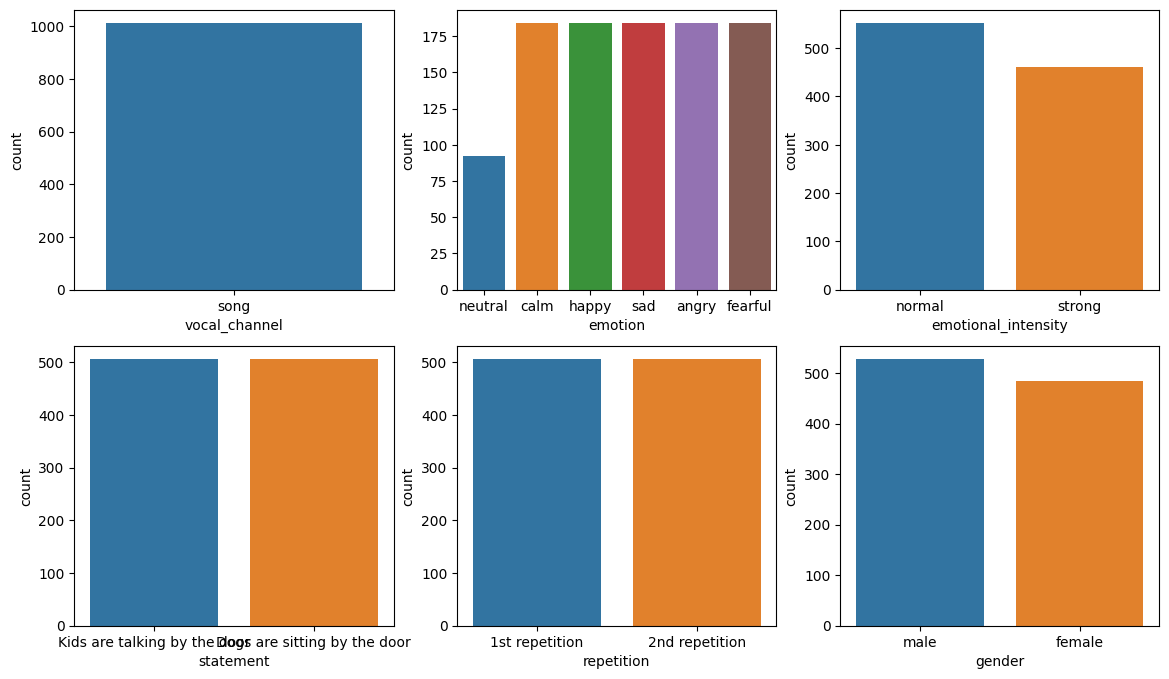

In [6]:
# Count Plots of all features
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, column in zip(axes.flatten(), df.columns[3:]):
    sns.countplot(data=df, x=column, ax=ax)

Plotting Audio Vectors


  0%|          | 0/1012 [00:00<?, ?it/s]

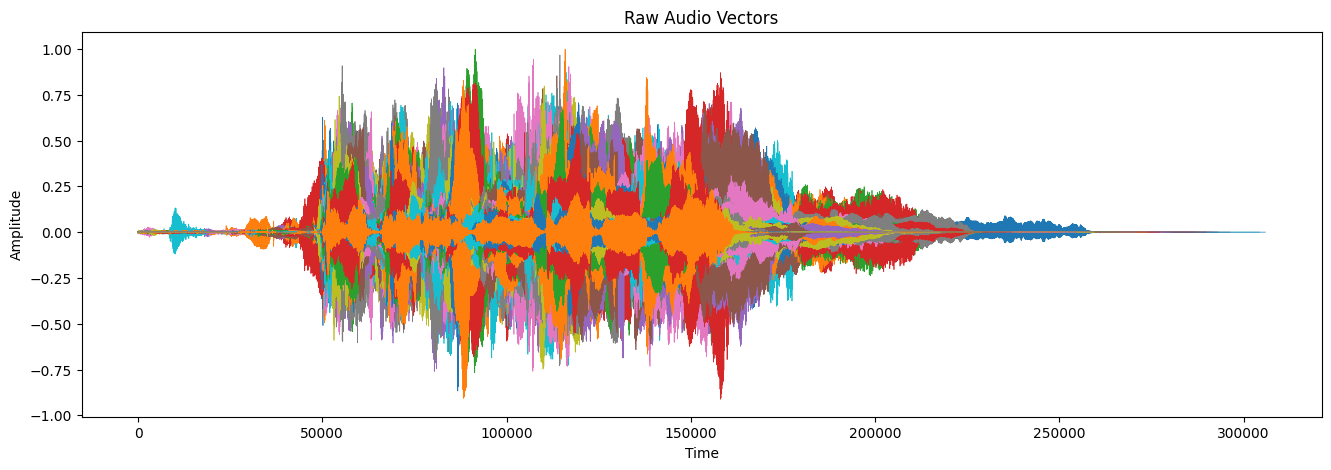

In [7]:
# Plot Each Audio Vector
print("Plotting Audio Vectors")
for audio_vector in tqdm(df["audio_vector"]):
    pd.Series(audio_vector).plot(
        figsize=(16, 5), 
        lw=0.5,
        ylabel="Amplitude",
        xlabel="Time",
        title="Raw Audio Vectors",
    )
plt.show()

Computing Maximum Loudness
Maximum Loudness Computed
Peak Normalising Audio Vectors
Plotting Peak Normalised Audio Vectors


  0%|          | 0/1012 [00:00<?, ?it/s]

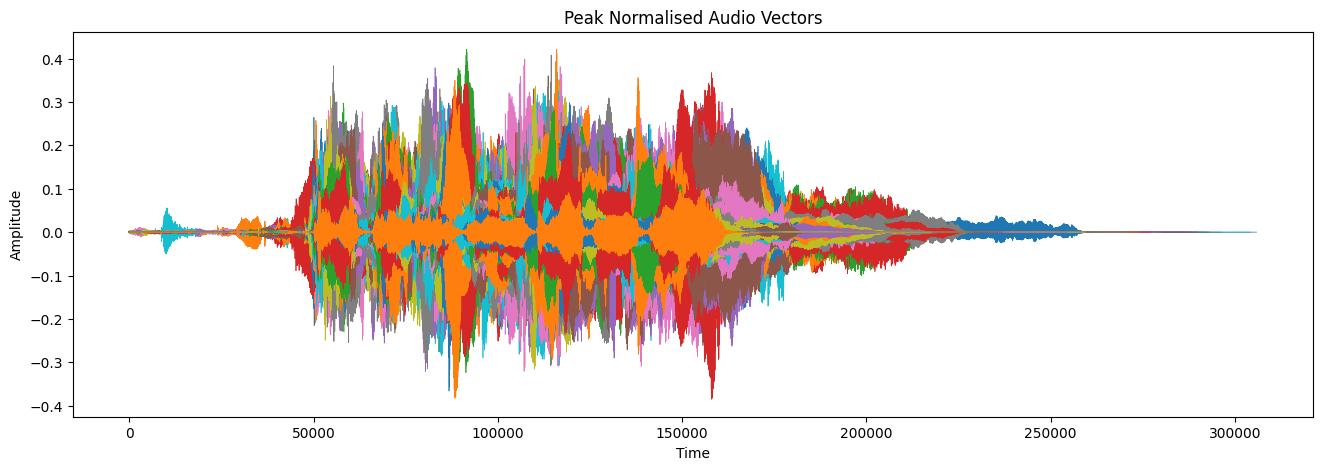

In [8]:
# Peak Normalisation with LUFS

# Get the Maximum Loudness
maximum_loudness = compute_maximum_loudness(df["audio_vector"].values)

# Normalise the audio vectors
print("Peak Normalising Audio Vectors")
normalised_audio_vectors = df["audio_vector"].apply(peak_normalize, args=(maximum_loudness,))

# Update the original Dataframe
df["audio_vector"] = normalised_audio_vectors

# Plot Each Audio Vector
print("Plotting Peak Normalised Audio Vectors")
for audio_vector in tqdm(df["audio_vector"]):
    pd.Series(audio_vector).plot(
        figsize=(16, 5), 
        lw=0.5,
        ylabel="Amplitude",
        xlabel="Time",
        title="Peak Normalised Audio Vectors",
    )
plt.show()

In [ ]:
# Clipping and Padding
clipped_padded_vectors = pd.Series(
    clip_audio_arrays(
        df["audio_vector"].values, 
        desired_length=int(df["audio_vector"].map(len).mean()), 
        top_db=30
        )
    )

# Replace the audio vectors with the clipped and padded vectors in original dataframe
df["audio_vector"] = clipped_padded_vectors.values

# # Audio overlap plot to check if the audio is clipped and padded properly
# print("Plotting Audio Overlap")
# for audio in tqdm(df["audio_vector"]):
#     pd.Series(audio).plot(
#     figsize=(16, 5), 
#     lw=0.5,
#     ylabel="Amplitude",
#     xlabel="Time",
#     title="Audio Overlap",
# )
# plt.show()

In [ ]:
# Configure openSMILE
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    multiprocessing=True,
    num_workers=32,
    verbose=True,
    sampling_rate=48000,
)

# Extract features
features_list = []
for audio_vector in tqdm(df["audio_vector"]):

        # Compute OpenSMILE features
        features = smile.process_signal(audio_vector, sampling_rate=48000)

        # Extract min, mean, std, max and rename the columns
        min = features.min().add_suffix("_min")
        means = features.mean().add_suffix("_mean")
        stds = features.std().add_suffix("_std")
        max = features.max().add_suffix("_max")

        # Concatenate the features
        features = pd.concat([min, means, stds, max], axis=0)

        # Append the features to the list
        features_list.append(features)

# Features and Targets Dataframes
features_df = pd.DataFrame(features_list)
targets_df = df["emotion"].astype("category")
combined_df = features_df.assign(target=targets_df.values)

In [ ]:
# Standardize the features (Z-Score Normalization)
feature_standard = StandardScaler()
feature_standard.fit(features_df)
normal_features_df = pd.DataFrame(feature_standard.transform(features_df), columns=features_df.columns)

# One Hot Encode the Targets
label_encoded_targets_df = pd.DataFrame(targets_df.cat.codes, columns=["target"])
oneHotEncoder = OneHotEncoder().fit(label_encoded_targets_df)
one_hot_encoded_targets_df = pd.DataFrame(oneHotEncoder.transform(label_encoded_targets_df).toarray(), columns=targets_df.cat.categories)

# Train Test Split - Label Encoded Targets
X_train, X_test, y_train, y_test = train_test_split(normal_features_df, targets_df, test_size=0.1, random_state=42)
print(f"Training features shape: {X_train.shape}")
print(f"Training Labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing Labels shape: {y_test.shape}")

In [ ]:
# 1) Logistic Regression

classifier = LogisticRegression(class_weight='balanced', solver="saga", max_iter=5000, n_jobs=-1, random_state=42)
print()
print("----------Training Logistic Regression----------")
print()
classifier.fit(X_train, y_train.squeeze())

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
classif_report = classification_report(y_test, y_pred, target_names=targets_df.cat.categories.values)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print(classif_report)
print()

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets_df.cat.categories.values)
cm_disp.plot()
plt.show()

# Get Logistic Regression Top Features
lr_top_features = set(X_train.loc[:, SelectFromModel(classifier, prefit=True, max_features=150).get_support()].columns.tolist())

In [ ]:
# 2) SVC

classifier = SVC(kernel='linear', max_iter=-1, class_weight='balanced', random_state=42)
print()
print("----------Training Support Vector Classification----------")
print()
classifier.fit(X_train, y_train.squeeze())

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
classif_report = classification_report(y_test, y_pred, target_names=targets_df.cat.categories.values,)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print(classif_report)
print()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets_df.cat.categories.values)
disp.plot()
plt.show()

# Get Support Vector Classifier Top Features
svc_top_features = set(X_train.loc[:, SelectFromModel(classifier, prefit=True, max_features=150).get_support()].columns.tolist())

In [ ]:
# 3) NuSVC

classifier = NuSVC(max_iter=-1, class_weight='balanced', kernel='rbf', random_state=42, nu=0.08)
print()
print("----------Training Nu-Support Vector Classification----------")
print()
classifier.fit(X_train, y_train.squeeze())

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
classif_report = classification_report(y_test, y_pred, target_names=targets_df.cat.categories.values,)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print(classif_report)
print()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets_df.cat.categories.values)
disp.plot()
plt.show()

In [ ]:
# 4) Random Forest

classifier = RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='balanced', random_state=42)
print()
print("----------Training Random Forest----------")
print()
classifier.fit(X_train, y_train.squeeze())

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
classif_report = classification_report(y_test, y_pred, target_names=targets_df.cat.categories.values)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print(classif_report)
print()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets_df.cat.categories.values)
disp.plot()
plt.show()

# Get Random Forest Classifier Top Features
rf_top_features = set(X_train.loc[:, SelectFromModel(classifier, prefit=True, max_features=150).get_support()].columns.tolist())

In [ ]:
# 5) Extra Trees

classifier = ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced', random_state=42)
print()
print("----------Training Extra Trees Classifier----------")
print()
classifier.fit(X_train, y_train.squeeze())

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
classif_report = classification_report(y_test, y_pred, target_names=targets_df.cat.categories.values)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print(classif_report)
print()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets_df.cat.categories.values)
disp.plot()
plt.show()

# Get Random Forest Classifier Top Features
et_top_features = set(X_train.loc[:, SelectFromModel(classifier, prefit=True, max_features=150).get_support()].columns.tolist())

# Deep Learning

In [ ]:
# Train Test Split - One Hot Encoded Targets
X_train, X_test, y_train, y_test = train_test_split(normal_features_df, one_hot_encoded_targets_df, test_size=0.1, random_state=42)

# Update the features dataframe with the top features
# Intersect the top features of all the classifiers
top_features = set.intersection(lr_top_features, svc_top_features, rf_top_features, et_top_features)
X_train = X_train.loc[:, list(top_features)]
X_test = X_test.loc[:, list(top_features)]

print(f"Training features shape: {X_train.shape}")
print(f"Training Labels shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing Labels shape: {y_test.shape}")

In [ ]:
def get_model(nInputFeatures):

    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2'))
    model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer='l2'))
    model.add(tf.keras.layers.Dense(6, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'],
    )

    model.build(input_shape=(None, nInputFeatures),)

    print(model.summary())

    return model

In [ ]:
# Generate Model
model = get_model(nInputFeatures=len(top_features))

log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Fit the Model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=True,
    validation_data=(X_test, y_test),
    use_multiprocessing=True,
    callbacks=[tensorboard_callback],
)

# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r',
           label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],
           color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Load the saved Model
model = tf.keras.models.load_model("./deep89.h5")

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r',
           label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'],
           color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Pridiciton of Testset
y_pred = model.predict(X_test)
y_pred = oneHotEncoder.inverse_transform(y_pred).squeeze()
y_test_inverse = oneHotEncoder.inverse_transform(y_test).squeeze()

# Confusion Matrix
acc_score = accuracy_score(y_test_inverse, y_pred)
classif_report = classification_report(y_test_inverse, y_pred, target_names=targets_df.cat.categories.values,)
cm = confusion_matrix(y_test_inverse, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print(classif_report)
print()

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=targets_df.cat.categories.values)
disp.plot()
plt.show()